# Operations

### Librarias utilizadas

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Point
import warnings
from rasterio.sample import sample_gen
warnings.filterwarnings("ignore", category=RuntimeWarning)


### Se carga el set de datos

In [117]:
# Poligono de La Union
union=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_poligono/la_union.shp")
# Dataset de parcelas
parc=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_parcelas/parcelas.shp")
# Dataset de mineria
miner=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_mineria/mineria.shp")
# Dataset de suelos
soil=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_suelos/suelos.shp")
# Dataset de vocacion
voca=gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_vocacion/vocacion.shp")
# Raster de elevación
elev_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/elevation.tif'
# Dataset de vias
vias = gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_vias/vias.shp")
# Raster de temperatura media anual
temp_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/temp.tif'
# Raster de precipitacion media anual
prec_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/prec.tif'
# Raster de radiacion media anual
rad_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/rad.tif'
# Raster de vapor medio anual
vap_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/vap.tif'
# Raster de velocidad del viento media anual
wind_path='/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/wind.tif'

### Afectación Minera de cada parcela

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/3142238277.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/3142238277.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


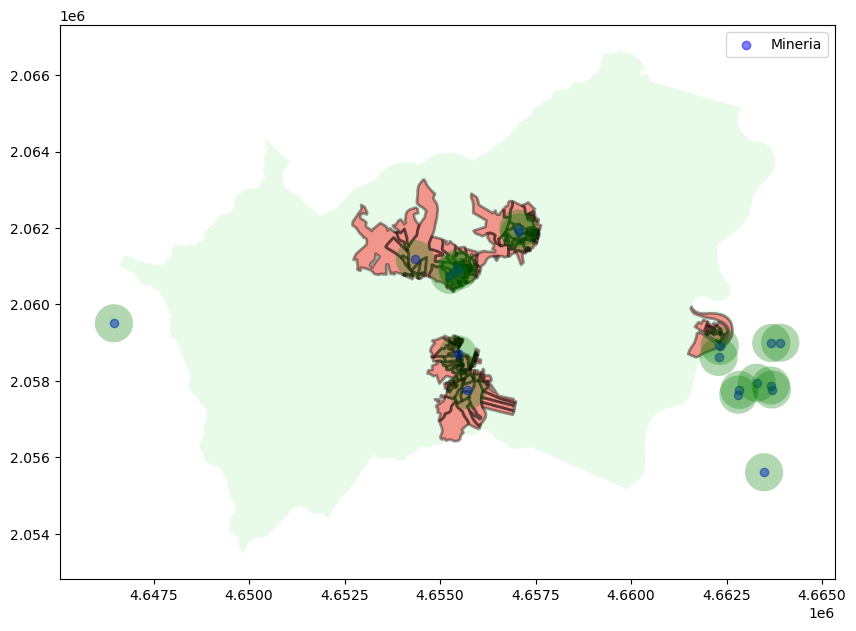

In [64]:
if parc.crs != miner.crs:
    parc = parc.to_crs(miner.crs)
# Se hace un buffer para los puntos de mineria
mineria_buffered=miner.buffer(500)
# Los puntos con buffer son guardados como Geodataframe
mineria_buffered_gdf = gpd.GeoDataFrame(geometry=mineria_buffered)
# Se seleccionan solo aquellas parcelas que se intersecan con las zonas (buffer) de mineria
affected_parc = parc[parc.geometry.intersects(mineria_buffered_gdf.unary_union)]
# Se exporta el archivo a la carpeta results 
affected_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/miner_parc.geojson", driver="GeoJSON")
# Se grafican aquellos predios afectados junto a los puntos donde hay mineria
fig, ax = plt.subplots(figsize=(10, 10))
union.plot(ax=ax, color='lightgreen', alpha=0.2, label='Municipio')
affected_parc.plot(ax=ax, color='red', edgecolor='black', linewidth=2, alpha=0.4, label='Predios Afectados')
miner.plot(ax=ax, color='blue', alpha=0.5, label='Mineria')
mineria_buffered.plot(ax=ax, color='green', alpha=0.3, label='Buffer Zone')

plt.legend()
plt.show()

### Pendiente de cada parcela

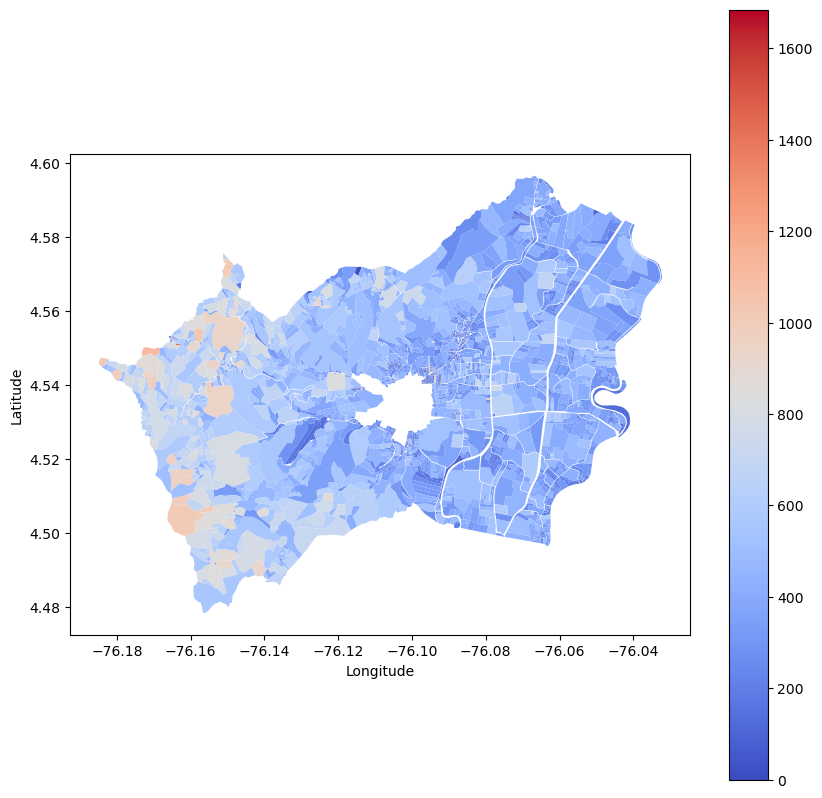

In [69]:
# Se abre la imagen y se lee la primera banda (elevacion)
with rasterio.open(elev_path) as src:
    elev=src.read(1)
    dx, dy = np.gradient(elev)
    # Se calcula la pendiente
    slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

    slopes = []
    # Se igualan los sistemas de coordenadas de ambos elementos
    if parc.crs != src.crs:
        parc = parc.to_crs(src.crs)
    # Se extrae el valor de pendiente para cada predio
    for i,row in parc.iterrows():
        geom = row['geometry']
        geom_json = [geom.__geo_interface__]
        out_image, out_transform = mask(src, geom_json, crop=True)
        valid_values = out_image[~np.isnan(out_image)]
        avg_slope = valid_values.mean() if valid_values.size > 0 else None
        slopes.append(avg_slope)
# Se guarda la informacion de los predios junto al atributo slope que contiene la pendiente de cada uno
slope_parc=parc
slope_parc['slope']=slopes
slope_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/slope_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
slope_parc.plot(column='slope', ax=ax, legend=True,
                           cmap='coolwarm')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()

### Vocación de cada parcela

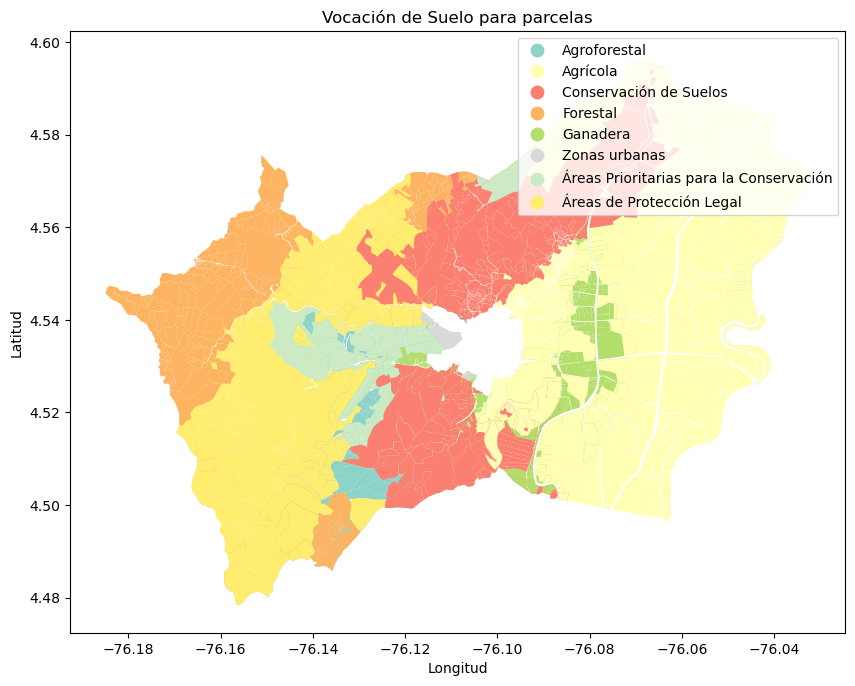

In [58]:
# Se igualan los sistemas de coordenadas
if parc.crs != voca.crs:
    voca = voca.to_crs(parc.crs)

voca_parc = gpd.sjoin(parc, voca, how="left", predicate="intersects")

voca_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/voca_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'Vocacion'
voca_parc.plot(column='Vocacion', ax=ax, legend=True,
                           cmap='Set3')  

# Agregar título y etiquetas si es necesario
ax.set_title("Vocación de Suelo para parcelas")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Mostrar el gráfico
plt.show()


### Propiedades edafoclimaticas de cada parcela

In [94]:
temp_path

'/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_clima/temp.tif'

In [103]:
parc = gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/data/data_parcelas/parcelas.shp")


# Se abre la imagen y se lee la primera banda (elevacion)
stats = zonal_stats(parc, wind_path, stats=["sum"])
print(stats)

[{'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': 0.8666666746139526}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': 0.8666666746139526}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': 0.8666666746139526}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': None}, {'sum': 0.84

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/2924285570.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


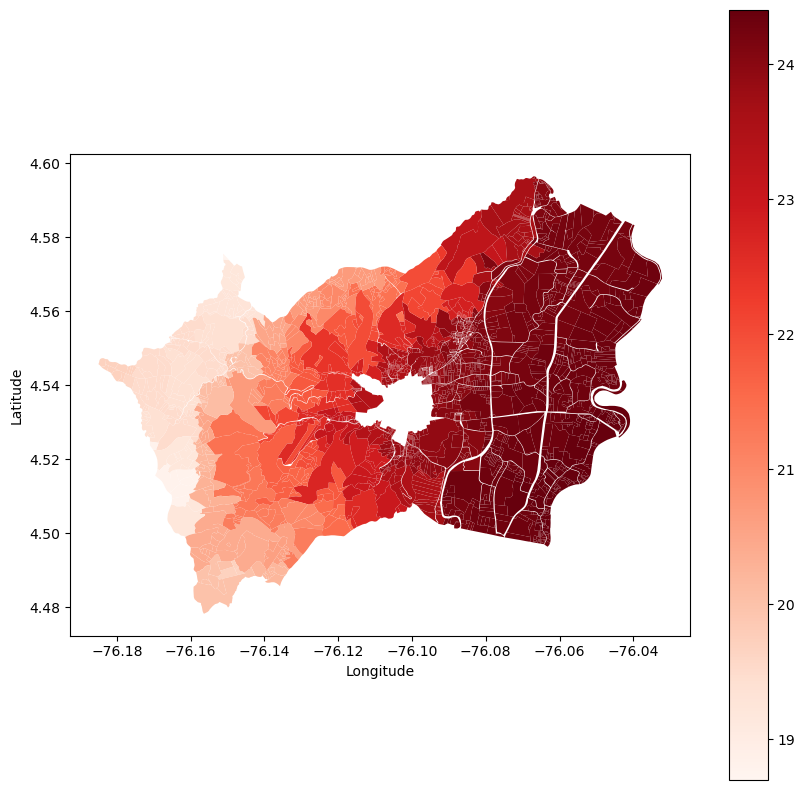

In [111]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(temp_path) as src:
    values = [x[0] for x in src.sample(coords)]

temp_parc=parc
temp_parc['temp']=values
temp_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/temp_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
temp_parc.plot(column='temp', ax=ax, legend=True,
                           cmap='Reds')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()


/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/2438701001.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


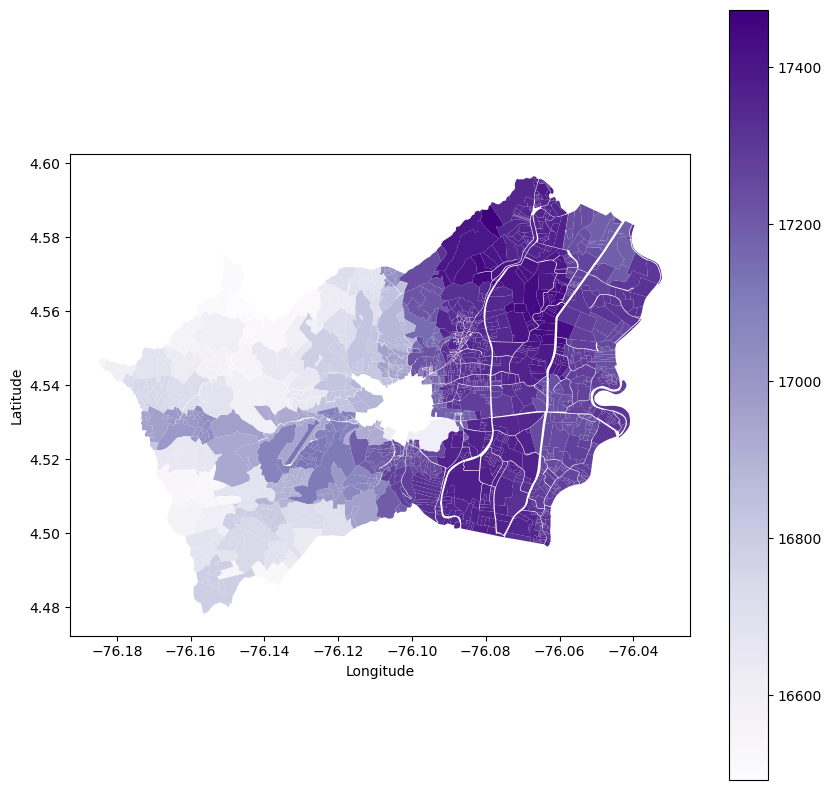

In [118]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(rad_path) as src:
    values = [x[0] for x in src.sample(coords)]

rad_parc=parc
rad_parc['rad']=values
rad_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/rad_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
rad_parc.plot(column='rad', ax=ax, legend=True,
                           cmap='Purples')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/318291765.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


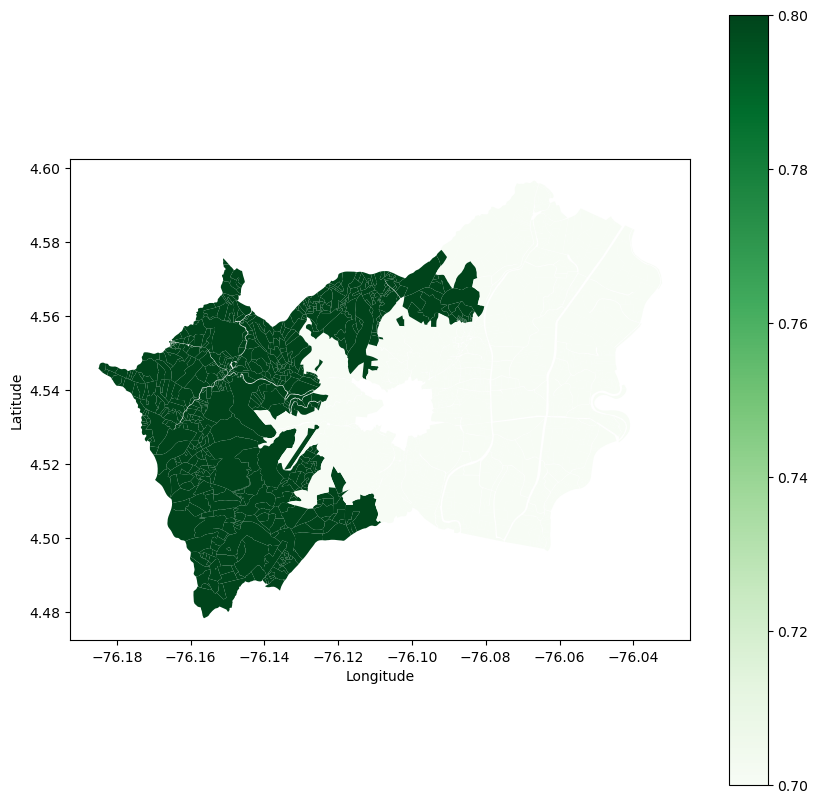

In [119]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(wind_path) as src:
    values = [x[0] for x in src.sample(coords)]

wind_parc=parc
wind_parc['wind']=values
wind_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/wind_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
wind_parc.plot(column='wind', ax=ax, legend=True,
                           cmap='Greens')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/1538019311.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


<function matplotlib.pyplot.show(close=None, block=None)>

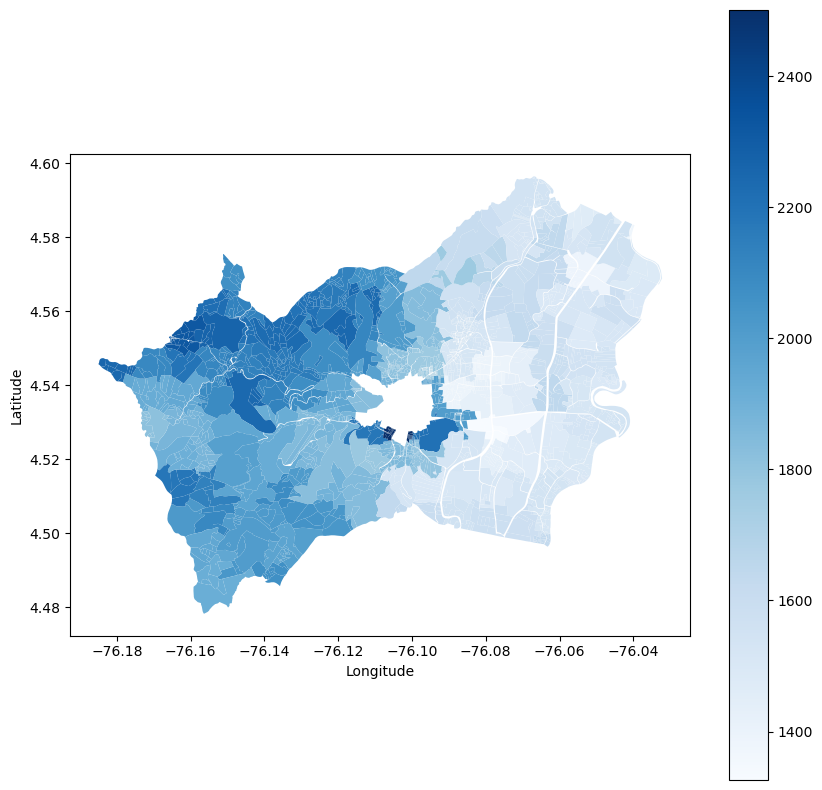

In [121]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(prec_path) as src:
    values = [x[0] for x in src.sample(coords)]

prec_parc=parc
prec_parc['prec']=values
prec_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/prec_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
prec_parc.plot(column='prec', ax=ax, legend=True,
                           cmap='Blues')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_8617/26120502.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(point.x, point.y) for point in parc.geometry.centroid]


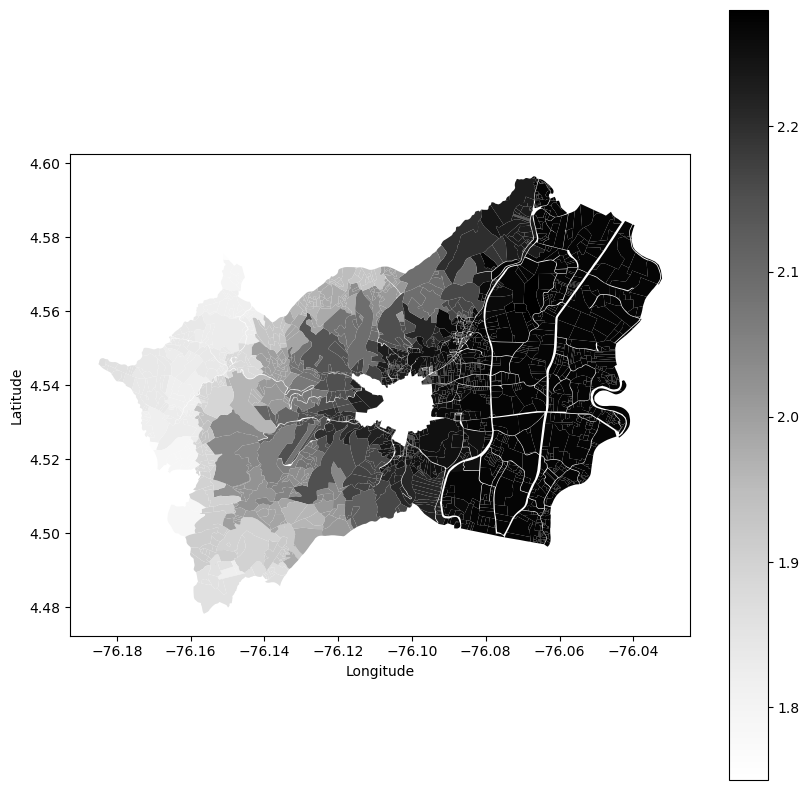

In [125]:
# Obtener centroides como lista de coordenadas
coords = [(point.x, point.y) for point in parc.geometry.centroid]

# Cargar ráster y obtener valores en esas coordenadas
with rasterio.open(vap_path) as src:
    values = [x[0] for x in src.sample(coords)]

vap_parc=parc
vap_parc['vap']=values
vap_parc.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/vap_parc.geojson", driver="GeoJSON")

fig, ax = plt.subplots(figsize=(10, 10))

# Graficar las parcelas con colores basados en la variable 'slope'
vap_parc.plot(column='vap', ax=ax, legend=True,
                           cmap='Grays')  

# Agregar título y etiquetas si es necesario

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Mostrar el gráfico
plt.show()

### Distancia a via principal de cada parcela

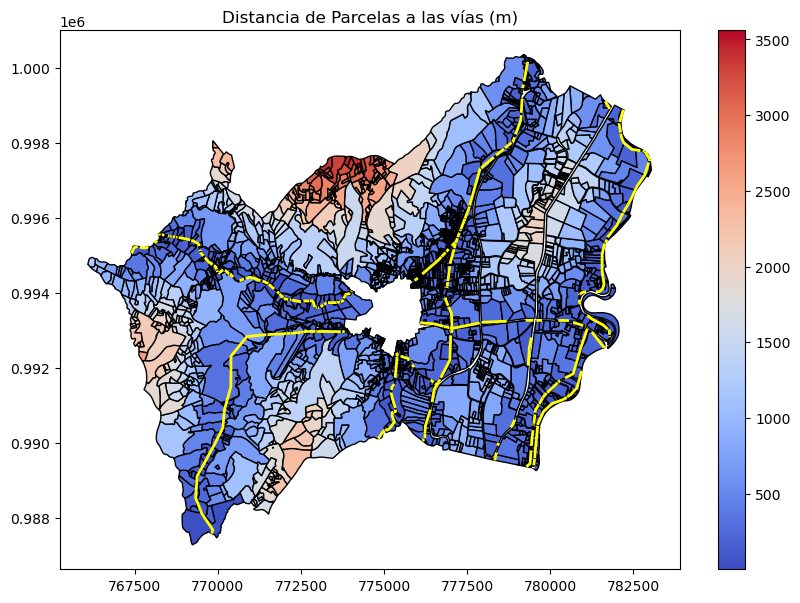

In [61]:
# Convertir a un CRS proyectado para Colombia (Magna-SIRGAS / UTM zona 18N - EPSG:3116)
parc = parc.to_crs("EPSG:3116")
vias = vias.to_crs("EPSG:3116")

new_parc=parc
# Obtener el centroide de cada parcela
new_parc['centroide'] = new_parc.geometry.centroid

# Calcular la distancia desde cada centroide de parcela a la vía más cercana
new_parc['distancia_a_via'] = new_parc['centroide'].apply(lambda geom: vias.geometry.distance(geom).min())

# Crear un nuevo GeoDataFrame con las parcelas y las distancias
parc_con_distancia = new_parc.drop(columns=['centroide'])

# Guardar el resultado en un nuevo archivo
parc_con_distancia.to_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Proyecto/Project_SIG/results/dist_parc.geojson", driver="GeoJSON")

# Generar el mapa
fig, ax = plt.subplots(figsize=(10, 7))
cbar = parc_con_distancia.plot(column='distancia_a_via', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')
vias.plot(color='yellow', linewidth=2, ax=ax)
ax.set_title("Distancia de Parcelas a las vías (m)")
ax.set_aspect('auto')  # Ajustar el aspecto para evitar errores

# Mostrar el gráfico
plt.show()